# Regresión

In [1]:
import keras
keras.__version__

'2.10.0'

Pasamos de estudiar dos ejemplos de clasificación a un ejemplo de regresión, intentando predecir un valor continuo en vez de una etiqueta discreta.


## El Dataset de Precios de Casas de Boston

Intentaremos predecir el precio medio de casas de un barrio de Boston (a partir de datos de los años 70). Para ello, usaremos alguna información asociada a algunas de las casas de ese barrio: tasa de crimen, impuestos locales, etc.

A diferencia de los datasets vistos en los ejemplos anteriores, éste es realmente pequeño, apenas 506 anotaciones, que están divididas en 404/102 en entrenamiento/test. Además, cada una de las características de los datos de entrada usa una escala diferente, por ejemlo, algunos valores son proporciones (continuos en $[0,1]$), otros toman valores discretos entre 1 y 12, otros entre 0 y 100, etc.

Podemos echar un vistazo a los datos (recuerda que es posible que la primera vez que ejecutes estas instrucciones se descargue el dataset):

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)


Como se puede observar, cada dato tiene 13 características, que esperamos permitan obtener una relación funcional para predecir su precio, como por ejemplo:

1. Ratio de crimen per cápita.
2. Proporción de área residencial en lotes de 25,000 pies cuadrado.
3. ...

El objetivo es el valor medio de las casas, en miles de dólares:

In [5]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [6]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13


Los precios están, aproximadamente, entre 10,000\\$ y 50,000\\$ (precios de los años 70, claro).


## Preparando los datos

Sería problemático alimentar la red neuronal con los datos en bruto que proporciona el dataset, que hace uso de rangos tan diferentes. Si fuera así, la red debería aprender, además de la relación funcional, a adaptar automáticamente la heterogeneidad de los datos, lo que haría que el aprendizaje fuera más complicado. Por ello, una buena práctica de preprocesamiento consiste en hacer una normalización de cada característica: para cada una de ellas (una columna) se extrae la media de sus valores y se divide por su desviación estándar, de esta forma la nueva características estará centrada en 0 y con desviación estándar 1:

In [7]:
mean = train_data.mean(axis=0) # axis=0: columnas (media de cada columna)
train_data -= mean # train_data = train_data - mean
std = train_data.std(axis=0) # axis=0: columnas (desviación típica de cada columna)
train_data /= std  # train_data = train_data / std

test_data -= mean # test_data = test_data - mean
test_data /= std # test_data = test_data / std


Observa que las medias y desviaciones se calculan solo en los datos de entrenamiento, ya que no debemos hacer uso de la información de test para nada, aunque la renormalización se realiza a los datos de ambos conjuntos.


## Construyendo la red

Debido a que hay pocas muestras para el entrenamiento, vamos a usar una red muy pequeña, con solo 2 capas ocultas, cada una de 64 unidades. En general, cuantos menos datos tengamos de entrenamiento, mayor será el sobreajuste, así que usar una red pequeña puede mitigar este efecto porque el número de parámetros en toda la red es más bajo.

In [8]:
from keras import models # importamos el modelo secuencial (capa a capa)
from keras import layers # importamos las capas que vamos a usar (densas, convolucionales, recurrentes, etc) 

def build_model():
    red = models.Sequential()
    red.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    red.add(layers.Dense(64, activation='relu'))
    red.add(layers.Dense(1))
    red.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return red

Esta vez hemos creado una función que construye el modelo, en vez de hacerlo directamente. La razón es porque en el procedimiento de validación que veremos más adelante tendremos que construir varios modelos similares.

Observa que la red acaba en una capa con una sola unidad y sin activación (es lo que se llama una capa lineal). Esta configuración es habitual cuando se hace regresión escalar (de un solo valor), ya que las funciones de activación restringen el rango de la salida, por ejemplo, una `sigmoid` aprende a predecir valores en $[0,1]$, pero una activación lineal puede aprender cualquier valor.

Observa también que se usa `mse` como función de pérdida, habitual en el caso de problemas de regresión. Para monitorizar el entrenamiento usamos `mae`, *Mean Absolute Error*, que es el valor absoluto de la diferencia entre las predicciones y los objetivos. Por ejemplo, un MAE de 0.5 en este problema significa que nuestras predicciones difieren en unos \$500 de media.

## K-validación cruzada

Para evaluar la red mientras ajustamos los hiperparámetros (como el número de epochs a usar), podríamos dividir simplemente el conjunto de entrenamiento en entrenamiento y validación, tal y como hicimos en ejemplos anteriores. Sin embargo, debido a que hay muy pocas muestras, el conjunto de validación acabaría siendo muy pequeño (unas 100 muestras), por lo que las métricas de validación pueden depender excesivamente de qué muestras concretas han terminado en cada conjunto, mostrando, posiblemente, una gran varianza.

La mejor práctica en este tipo de situaciones es usar una **K-validación cruzada**, que consiste em dividir los datos disponibles en $K$ particiones (normalmente, entre 4 y 5), después instanciar $K$ modelos exactos, y entonces entrenar cada uno de los modelos usando $K-1$ de las particiones anteriores y evaluar sobre la restante. La métrica de evaluación será la media de las $K$ métricas obtenidas sobre las validaciones de cada modelo.

In [9]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    red = build_model()
    # Train the model (in silent mode, verbose=0)
    red.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = red.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
all_scores

[1.9210528135299683, 2.5943808555603027, 2.8234128952026367, 2.375842809677124]

In [11]:
np.mean(all_scores)

2.428672343492508


Como puedes observar, las posibles métricas de validación varían mucho (dependiendo de la ejecución, de 2.1 a 2.9, puede depender de la ejecución concreta), por lo que la media (2.39) es mucho más fiable que cada una de las otras valoraciones por separado... este es precisamente el valor de la K-validacion cruzada. Todavía estamos con un error significativo de unos 2,400\\$ en precios que están en un rango de entre 10,000\\$ y 50,000\\$, así que intentemos entrenar la red durante un poco más de tiempo: 200 epochs. Con el fin de guardar un registro de cómo de bien funciona el modelo en cada epoch, vamos a modificar el bucle de entrenamiento para almacenar el score de validación en cada epoch:


In [12]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [13]:
num_epochs = 500
all_mae_entrenamientos = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    red = build_model()
    # Train the model (in silent mode, verbose=0)
    entrenamiento = red.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_entrenamiento = entrenamiento.history['val_mae']
    all_mae_entrenamientos.append(mae_entrenamiento)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Ahora podemos calcular la media de los valores MAE en cada epoch:


In [14]:
average_mae_entrenamiento = [
    np.mean([x[i] for x in all_mae_entrenamientos]) for i in range(num_epochs)]

Y representarlo:


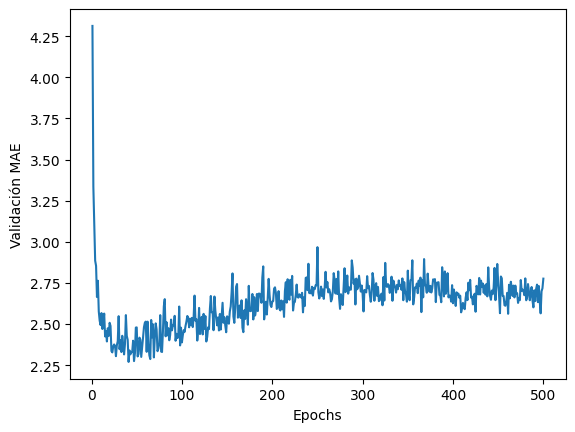

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_entrenamiento) + 1), average_mae_entrenamiento)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()


Puede ser un poco difícil extraer conocimiento de esta gráfica debido a los problemas de escala que presenta y a la alta varianza, así que podemos hacer lo siguiente:

* Omitir los primeros 10 puntos de los datos, que parecen mostrar una escala distinta al resto de la curva.
* Reemplazar cada punto con una media exponencial de los puntos anteriores, con el fin de obtener una curva más suave.

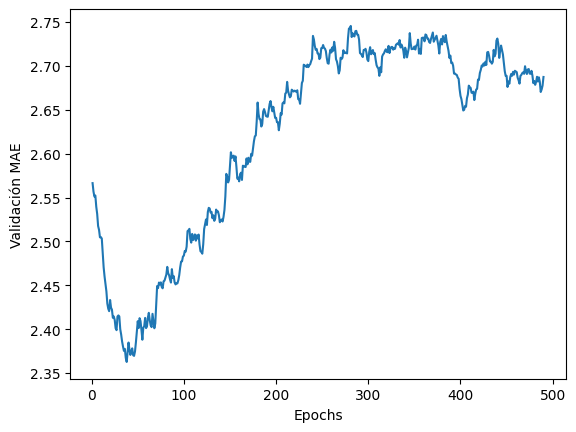

In [16]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_entrenamiento = smooth_curve(average_mae_entrenamiento[10:])

plt.plot(range(1, len(smooth_mae_entrenamiento) + 1), smooth_mae_entrenamiento)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()


De acuerdo con esta nueva gráfica, parece que el MAE de validación deja de mejorar tras 100-130 epochs, a partir de entonces empieza a haber sobreajuste.

Tras haber ajustado otros parámetros del modelo (por ejemplo, el tamaño de las capas ocultas), podemos entrenar una versión final del modelo sobre todos los datos de entrenamiento y medir el rendimiento sobre los datos de test:

In [17]:
# Get a fresh, compiled model.
red = build_model()
# Train it on the entirety of the data.
red.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = red.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 16.6684 - mae: 2.5115


In [18]:
test_mae_score

2.511481761932373

Que sigue mostrando un error todavía muy alto, rondando los \$2,500.


## Conclusiones

* La regresión hace uso de funciones de pérdida distintas a la clasificación. La más común suele ser la *Mean Squared Error* (MSE).
* Además, las métricas de evaluación también suelen ser distintas, por ejemplo, *Mean Absolute Error* (MAE). El término "accuracy" aquí no tiene sentido.
* Cuando las características de los datos de entrada usan diferentes rangos, cada una de ellas ha de ser normalizada independientemente en la etapa de preprocesamiento.
* Cuando tenemos pocos datos, usar K-validación cruzada puede ser un buen método para evaluar el modelo de forma más fiable.
* Cuando hay pocos datos, es preferible usar redes pequeñas con pocas capas (normalmente, 1 o 2) con el fin de evitar un sobreajuste exagerado.